Importing Dataset

In [25]:
import torch
import os
from PIL import Image 
import numpy as np


class MyDataset:
    def __init__(self, root_dir, transform):
        root_dir = 'Soil types'
        assert os.path.exists(root_dir), 'Data does not exist'
        self.transform = transform
        data_files = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]
        data_label = 0
        self.data_all = {}
        self.data_all['label'] = []
        self.data_all['file_name'] = []
        for file in data_files:    
            data_samples = os.listdir(file)
            for data in data_samples:
                data_file_name = os.path.join(file, data)
                self.data_all['label'].append(data_label)
                self.data_all['file_name'].append(data_file_name)
            data_label += 1 

    def __len__(self):
        return len(self.data_all['label'])

    def __getitem__(self, index):
        # print(self.data[index])
        image = Image.open(self.data_all['file_name'][index])
        newsize = (256,256)
        image = image.resize(newsize)
        image = np.array(image)
        label = np.array(self.data_all['label'][index])


        if self.transform:
            image = torch.from_numpy(image)
            label = torch.from_numpy(label)

        data_point = {'label': label, 'image': image}
        return data_point

Dividing data set

In [39]:
import torch
import random
import torch.utils.data as data
from torch.utils.data import DataLoader

root_dir = 'Soil types'
dataset = MyDataset(root_dir, transform=True)

train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = data.random_split(dataset,[train_size, val_size])

batch_size = 8
dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)

tensor(2, dtype=torch.int32)
torch.Size([256, 256, 3])


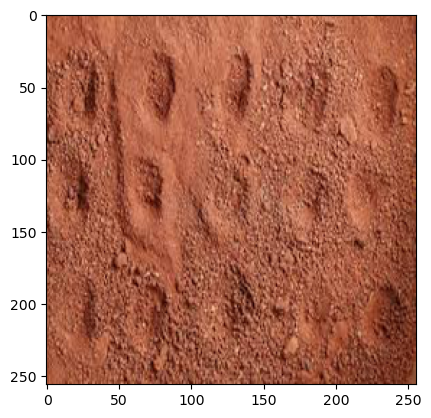

In [40]:
import matplotlib.pyplot as plt
test = dataset[69]
test_image = test['image']
plt.imshow(test_image)

print(test['label'])
print(test_image.shape)

Creating nn

In [28]:
import torch.nn as nn

class MyNetwork(nn.Module):
    def __init__(self, ngpu):
        super(MyNetwork, self).__init__()
        self.ngpu = ngpu
        self.main = nn. Sequential(

            #change channels if accuracy not enough
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3), stride = (1,1), padding='valid', bias = True, padding_mode='zeros'),
            nn.ReLU(True),#activation function
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),#max pooling will half the image size
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride = (1,1), padding='valid', bias = True, padding_mode='zeros'),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride = (1,1), padding='valid', bias = True, padding_mode='zeros'),
            nn.ReLU(True),
            nn.Flatten(),#flat
            nn.Linear(115200, 512, bias=True),#fully connected layer
            nn.ReLU(True),
            nn.Linear(512, 5, bias=True),#5 coz 5 classes of soil
            nn.Softmax(dim=1)#softmax activation function for last layer

            #add more layers based on need

        )
    def forward(self, input):
        return self.main(input)

In [30]:
from torchsummary import summary


ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


net = MyNetwork(ngpu =1).to(device)

summary(net, [3,256,256])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 5]                   --
|    └─Conv2d: 2-1                       [-1, 8, 254, 254]         224
|    └─ReLU: 2-2                         [-1, 8, 254, 254]         --
|    └─MaxPool2d: 2-3                    [-1, 8, 127, 127]         --
|    └─Conv2d: 2-4                       [-1, 16, 125, 125]        1,168
|    └─ReLU: 2-5                         [-1, 16, 125, 125]        --
|    └─MaxPool2d: 2-6                    [-1, 16, 62, 62]          --
|    └─Conv2d: 2-7                       [-1, 32, 60, 60]          4,640
|    └─ReLU: 2-8                         [-1, 32, 60, 60]          --
|    └─Flatten: 2-9                      [-1, 115200]              --
|    └─Linear: 2-10                      [-1, 512]                 58,982,912
|    └─ReLU: 2-11                        [-1, 512]                 --
|    └─Linear: 2-12                      [-1, 5]                   2,5

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 5]                   --
|    └─Conv2d: 2-1                       [-1, 8, 254, 254]         224
|    └─ReLU: 2-2                         [-1, 8, 254, 254]         --
|    └─MaxPool2d: 2-3                    [-1, 8, 127, 127]         --
|    └─Conv2d: 2-4                       [-1, 16, 125, 125]        1,168
|    └─ReLU: 2-5                         [-1, 16, 125, 125]        --
|    └─MaxPool2d: 2-6                    [-1, 16, 62, 62]          --
|    └─Conv2d: 2-7                       [-1, 32, 60, 60]          4,640
|    └─ReLU: 2-8                         [-1, 32, 60, 60]          --
|    └─Flatten: 2-9                      [-1, 115200]              --
|    └─Linear: 2-10                      [-1, 512]                 58,982,912
|    └─ReLU: 2-11                        [-1, 512]                 --
|    └─Linear: 2-12                      [-1, 5]                   2,5

Optimize

In [31]:
SGD_optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #change optimizer if accuracy less
#lr - learning rate
loss_func = nn.CrossEntropyLoss()
num_epochs = 10

In [44]:
import torch.nn.functional as F
for epoch in range(num_epochs):
    # train_accuracy = 0
    for i, data in enumerate(dataloader_train,0):

        SGD_optimizer.zero_grad()

        input = data['image'].to(device)
        
        label = data['label'].to(device)

        label_train = label.to(torch.int64)
        label_encoded = F.one_hot(label_train,5).squeeze(1)
        from numpy.linalg import inv

        out = net(input)

        # print(out.shape)
        loss = loss_func(out, label_encoded)
        loss.backward()
        SGD_optimizer.step()

        print(loss)

RuntimeError: Given groups=1, weight of size [8, 3, 3, 3], expected input[8, 256, 256, 3] to have 3 channels, but got 256 channels instead